In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# create dataset
dataset_dict ={
    'Outlook': ['sunny', 'sunny', 'overcast', 'rain', 'rain', 'rain', 'overcast', 'sunny', 'sunny', 'rain', 'sunny', 'overcast', 'overcast', 'rain', 'sunny', 'overcast', 'rain', 'sunny', 'sunny', 'rain', 'overcast', 'rain', 'sunny', 'overcast', 'sunny', 'overcast', 'rain', 'overcast'],
    'Temperature': [85.0, 80.0, 83.0, 70.0, 68.0, 65.0, 64.0, 72.0, 69.0, 75.0, 75.0, 72.0, 81.0, 71.0, 81.0, 74.0, 76.0, 78.0, 82.0, 67.0, 85.0, 73.0, 88.0, 77.0, 79.0, 80.0, 66.0, 84.0],
    'Humidity': [85.0, 90.0, 78.0, 96.0, 80.0, 70.0, 65.0, 95.0, 70.0, 80.0, 70.0, 90.0, 75.0, 80.0, 88.0, 92.0, 85.0, 75.0, 92.0, 90.0, 85.0, 88.0, 65.0, 70.0, 60.0, 95.0, 70.0, 78.0],
    'Wind': [False, True, False, False, False, True, True, False, False, False, True, True, False, True, True, False, False, True, False, True, True, False, True, False, False, True, False, False],
    'Num_Players': [52, 39, 43, 37, 28, 19, 43, 47, 56, 33, 49, 23, 42, 13, 33, 29, 25, 51, 41, 14, 34, 29, 49, 36, 57, 21, 23, 41]
}
df = pd.DataFrame(dataset_dict)
df.head()

,Outlook,Temperature,Humidity,Wind,Num_Players
0,sunny,85.0,85.0,False,52
1,sunny,80.0,90.0,True,39
2,overcast,83.0,78.0,False,43
3,rain,70.0,96.0,False,37
4,rain,68.0,80.0,False,28


In [2]:
# Onehot Encoding 'Outlook' column
df = pd.get_dummies(df, columns=['Outlook'],prefix='',prefix_sep='')
# Convert 'Wind' column to binary
df['Wind'] = df['Wind'].astype(int)
# Rearrange the columns
column_order = ['sunny','overcast','rain','Temperature','Humidity','Wind','Num_Players']
df = df[column_order]

# Split features and target
X,y = df.drop('Num_Players',axis=1),df['Num_Players']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.5,shuffle=False)

In [3]:
def calculate_split_mse(X_train,y_train,feature_name,split_point):
    # Create DataFrame and sort by Features
    analysis_df = pd.DataFrame({
        'feature':X_train[feature_name],
        'y_actual':y_train

    }).sort_values('feature')

    # Slit data and calculate means
    left_mask = analysis_df['feature'] <= split_point
    left_mean = analysis_df[left_mask]['y_actual'].mean()
    right_mean = analysis_df[~left_mask]['y_actual'].mean()

    # Calculate squared Difference
    analysis_df['squared_diff'] = np.where(
        left_mask,
        (analysis_df['y_actual'] - left_mean) ** 2,
        (analysis_df['y_actual'] - right_mean) ** 2
    )
    # Calculate MSEs and counts
    left_mse = analysis_df[left_mask]['squared_diff'].mean()
    right_mse = analysis_df[~left_mask]['squared_diff'].mean()
    n_left = sum(left_mask)
    n_right = len(analysis_df) - n_left

    # Calculate weighted average MSE
    weighted_mse = (n_left * left_mse + n_right * right_mse) / len(analysis_df)

    # Print results
    print(analysis_df)
    print(f"nResults for split at {split_point} on feature '{feature_name}':")
    print(f"Left child MSE (n={n_left}, mean={left_mean:.2f}): {left_mse:.2f}")
    print(f"Right child MSE (n={n_right}, mean={right_mean:.2f}): {right_mse:.2f}")
    print(f"Weighted average MSE: {weighted_mse:.2f}")

# Example usage:
calculate_split_mse(X_train, y_train, 'Temperature', 73.5)

    feature  y_actual  squared_diff
6      64.0        43       95.0625
5      65.0        19      203.0625
4      68.0        28       27.5625
8      69.0        56      517.5625
3      70.0        37       14.0625
13     71.0        13      410.0625
7      72.0        47      189.0625
11     72.0        23      105.0625
10     75.0        49       36.0000
9      75.0        33      100.0000
1      80.0        39       16.0000
12     81.0        42        1.0000
2      83.0        43        0.0000
0      85.0        52       81.0000
nResults for split at 73.5 on feature 'Temperature':
Left child MSE (n=8, mean=33.25): 195.19
Right child MSE (n=6, mean=43.00): 39.00
Weighted average MSE: 128.25


In [4]:
def evaluate_all_splits(X_train, y_train):
    """Evaluate all possible split points using midpoints for all features"""
    results = []

    for feature in X_train.columns:
        data = pd.DataFrame({'feature': X_train[feature], 'y_actual': y_train})
        splits = [(a + b)/2 for a, b in zip(sorted(data['feature'].unique())[:-1], 
                                          sorted(data['feature'].unique())[1:])]

        for split in splits:
            left_mask = data['feature'] <= split
            n_left = sum(left_mask)

            if not (0 < n_left < len(data)): continue

            left_mean = data[left_mask]['y_actual'].mean()
            right_mean = data[~left_mask]['y_actual'].mean()

            left_mse = ((data[left_mask]['y_actual'] - left_mean) ** 2).mean()
            right_mse = ((data[~left_mask]['y_actual'] - right_mean) ** 2).mean()

            weighted_mse = (n_left * left_mse + (len(data) - n_left) * right_mse) / len(data)

            results.append({'Feature': feature, 'Split_Point': split, 'Weighted_MSE': weighted_mse})

    return pd.DataFrame(results).round(2)

results = evaluate_all_splits(X_train, y_train)
print(results)

        Feature  Split_Point  Weighted_MSE
0         sunny          0.5         82.20
1      overcast          0.5        151.49
2          rain          0.5         78.97
3   Temperature         64.5        149.14
4   Temperature         66.5        144.64
5   Temperature         68.5        136.48
6   Temperature         69.5        151.19
7   Temperature         70.5        151.15
8   Temperature         71.5        134.52
9   Temperature         73.5        128.25
10  Temperature         77.5        134.26
11  Temperature         80.5        133.02
12  Temperature         82.0        134.62
13  Temperature         84.0        135.20
14     Humidity         67.5        149.14
15     Humidity         72.5        144.06
16     Humidity         76.5        140.91
17     Humidity         79.0        135.86
18     Humidity         82.5        148.91
19     Humidity         87.5        151.19
20     Humidity         92.5        148.05
21     Humidity         95.5        151.52
22         

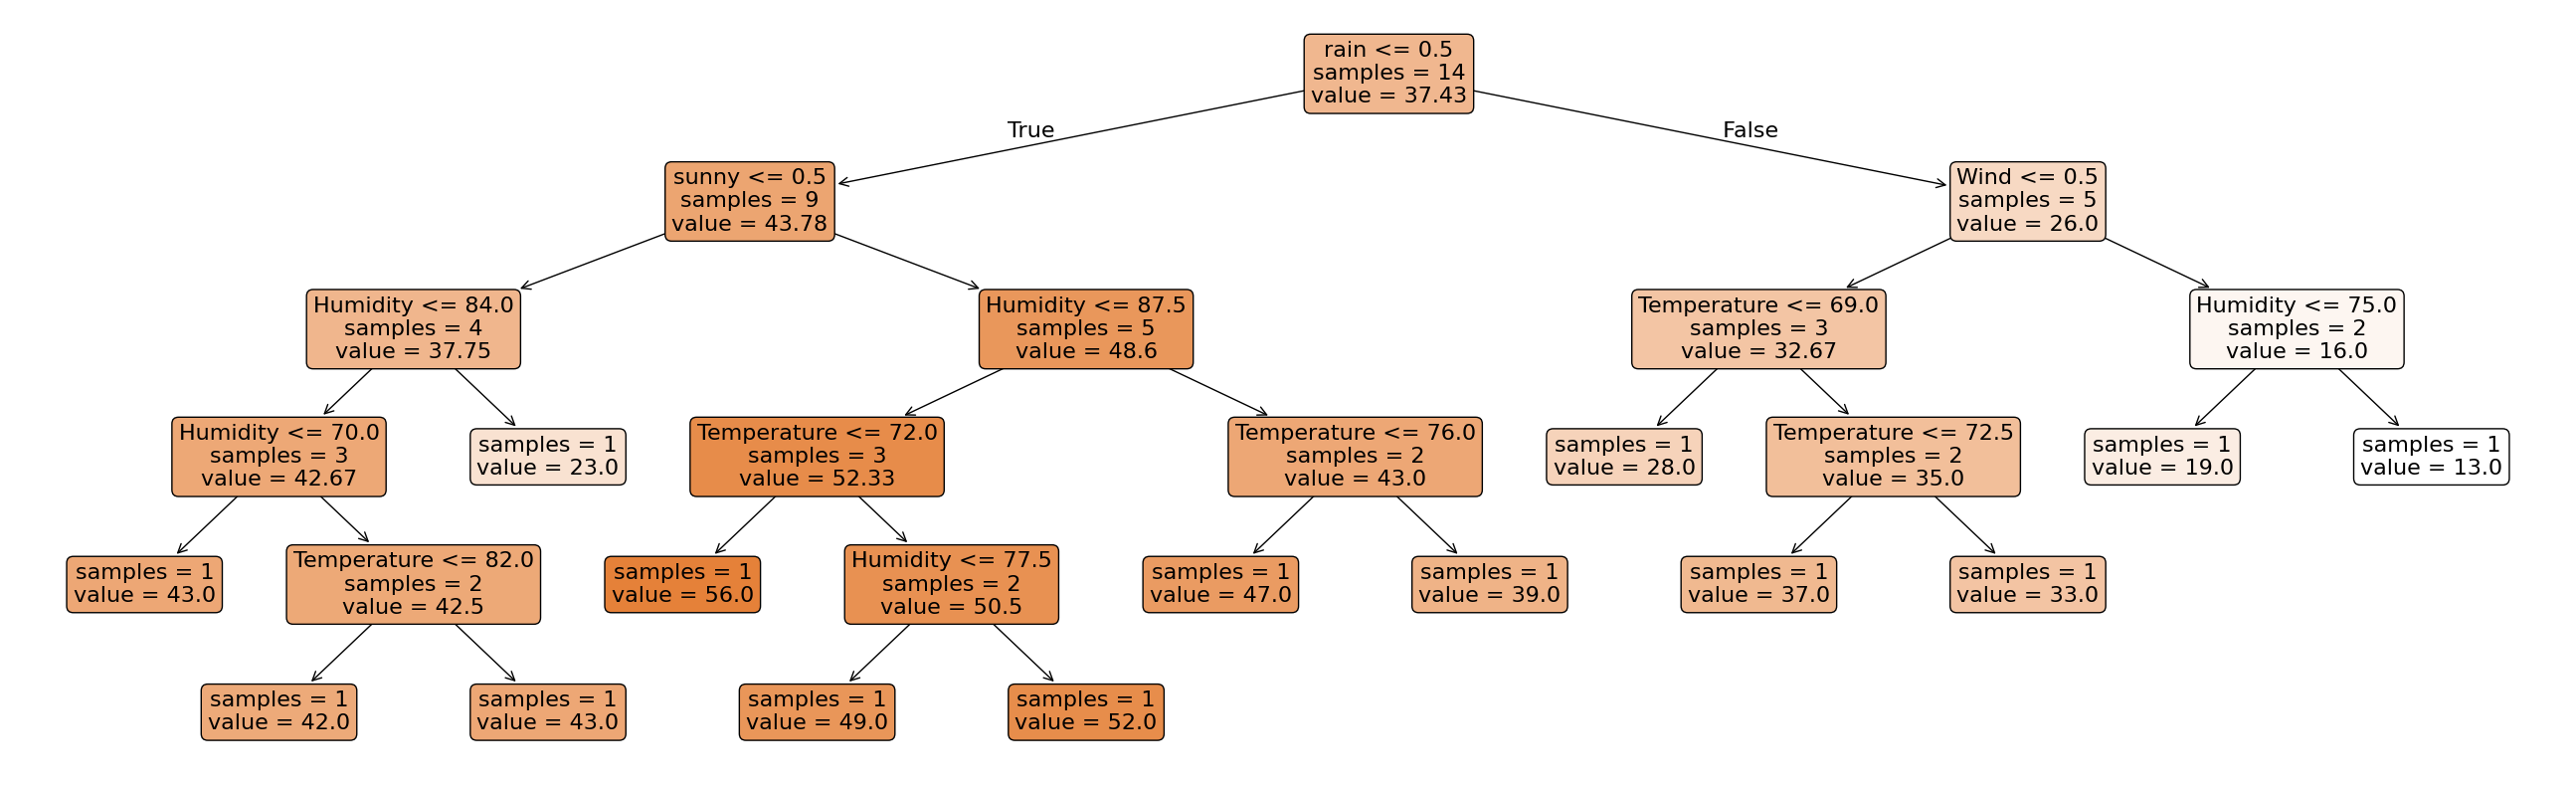

In [5]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Train the model
regr = DecisionTreeRegressor(random_state=42)
regr.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(26,8))
plot_tree(regr, feature_names=X.columns, filled=True, rounded=True, impurity=False, fontsize=16, precision=2)
plt.tight_layout()
plt.show()